<a href="https://colab.research.google.com/github/sahil301290/TSS2022-ThaparSummerSchool/blob/main/29Jun2022_CatsvsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Cats vs Dogs Classification**

###**1.1 Import all the important libraries**

In [1]:
!nvidia-smi

Wed Jun 29 15:21:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import random
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from sklearn.model_selection import train_test_split

###**1.2 Download and upzip the raw data**

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!unzip '/content/drive/MyDrive/TSS2022_Datasets/dogs-vs-cats.zip' &> /dev/null

###**1.3 Define our images sizes**

In [5]:
IMAGE_WIDTH = 60
IMAGE_HEIGHT = 60
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

###**1.4 Data Preprocessing**

#### **1.4.1 Loading our data and it's labels into a dataframe**

There are many ways we can do this, this way is relatively simple to follow.

`dog.1034234.jpg`

In [6]:
filenames = os.listdir("./dogs-vs-cats/train")

categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'class': categories
})
df.head()

,filename,class
0,dog.97.jpg,1
1,cat.409.jpg,0
2,cat.199.jpg,0
3,cat.449.jpg,0
4,dog.258.jpg,1


#### **1.4.2 Check the counts in each class**

In [7]:
df['class'].value_counts()

1    500
0    500
Name: class, dtype: int64

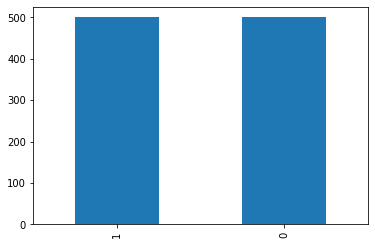

In [8]:
df['class'].value_counts().plot.bar()

#### **1.4.3 View a sample image**

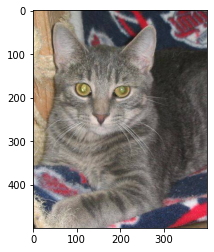

In [9]:
sample = random.choice(filenames)
image = load_img("./dogs-vs-cats/train/" + sample)
plt.imshow(image)

## **2. Create our CNN Model**

In [10]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0

## **3. Create our Data Generators**

In [11]:
df["class"] = df["class"].replace({0: 'cat', 1: 'dog'}) 
df.head()

,filename,class
0,dog.97.jpg,dog
1,cat.409.jpg,cat
2,cat.199.jpg,cat
3,cat.449.jpg,cat
4,dog.258.jpg,dog


#### **3.1 Split our dataset using train_test_split**

In [12]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=7)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [13]:
train_df.head()

,filename,class
0,dog.85.jpg,dog
1,dog.183.jpg,dog
2,dog.227.jpg,dog
3,dog.436.jpg,dog
4,dog.337.jpg,dog


In [14]:
validate_df.head()

,filename,class
0,cat.6.jpg,cat
1,dog.294.jpg,dog
2,dog.115.jpg,dog
3,dog.13.jpg,dog
4,dog.207.jpg,dog


**batch_size** determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.

**steps_per_epoch** the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.

**validation_steps** similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.

#### **3.2 Create our Training Data Generator**

In [15]:
batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./dogs-vs-cats/train/", 
    x_col = 'filename',
    y_col = 'class',
    target_size = IMAGE_SIZE,
    class_mode = 'categorical',
    batch_size = batch_size
)

Found 800 validated image filenames belonging to 2 classes.


#### **3.3 Create our Validation Data Generator**

In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dogs-vs-cats/train/", 
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 200 validated image filenames belonging to 2 classes.


#### **3.4 Creating an example Data Generator to load just a single image**

In [17]:
example_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./dogs-vs-cats/train/", 
    x_col='filename',
    y_col='class',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


#### **3.5 Preview that image**

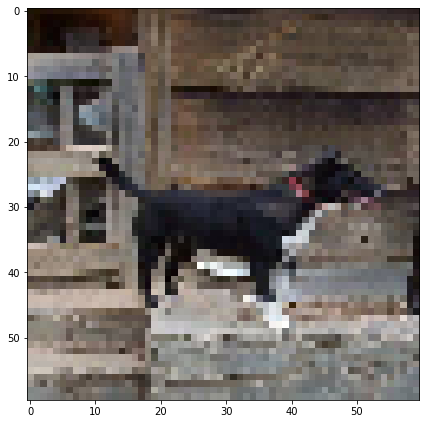

In [18]:
plt.figure(figsize=(6, 6))

for X_batch, Y_batch in example_generator:
    image = X_batch[0]
    plt.imshow(image)
    break

plt.tight_layout()
plt.show()

## **4. Start Training Our Model**

In [19]:
epochs = 5

history = model.fit(
    train_generator, 
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = 200//batch_size,
    steps_per_epoch = 800//batch_size,
)

Epoch 1/5
25/25 [==============================] - 14s 108ms/step - loss: 0.6988 - accuracy: 0.5088 - val_loss: 0.6845 - val_accuracy: 0.5521
Epoch 2/5
25/25 [==============================] - 2s 95ms/step - loss: 0.6795 - accuracy: 0.5713 - val_loss: 0.6836 - val_accuracy: 0.5781
Epoch 3/5
25/25 [==============================] - 2s 94ms/step - loss: 0.6757 - accuracy: 0.5537 - val_loss: 0.6769 - val_accuracy: 0.5365
Epoch 4/5
25/25 [==============================] - 2s 95ms/step - loss: 0.6546 - accuracy: 0.6413 - val_loss: 0.6661 - val_accuracy: 0.6042
Epoch 5/5
25/25 [==============================] - 3s 102ms/step - loss: 0.6419 - accuracy: 0.6237 - val_loss: 0.6408 - val_accuracy: 0.6094


#### **4.1 Saving the model**

In [20]:
model.save_weights("cats_vs_dogs_5_epochs.h5")

#### **4.2 View Training and Validation graphs for loss and accuracy**

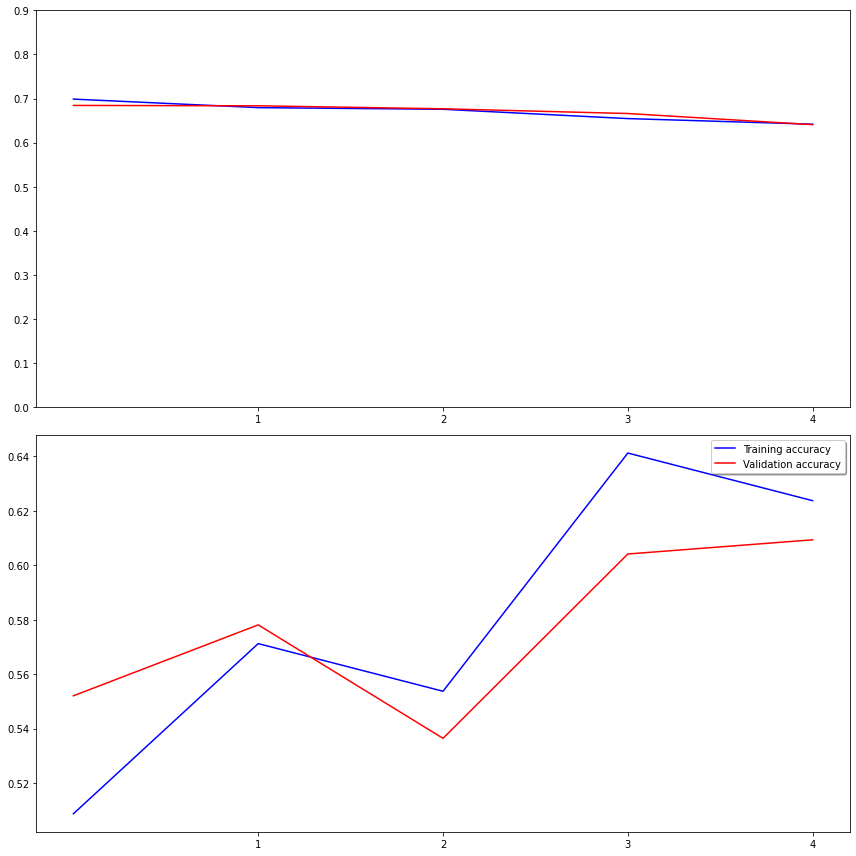

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#### **4.3 Get the predictions for our validation images**

In [22]:
predict = model.predict_generator(validation_generator, steps = np.ceil(200/batch_size))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


#### **4.4 Add it to our dataframe for easy viewing**

In [23]:
validate_df['predicted'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
validate_df['predicted'] = validate_df['predicted'].replace(label_map)
validate_df

,filename,class,predicted
0,cat.6.jpg,cat,dog
1,dog.294.jpg,dog,cat
2,dog.115.jpg,dog,dog
3,dog.13.jpg,dog,dog
4,dog.207.jpg,dog,dog
...,...,...,...
195,cat.272.jpg,cat,dog
196,cat.432.jpg,cat,cat
197,dog.372.jpg,dog,cat
198,cat.439.jpg,cat,cat


## **5. Inference on a batch of images from our validation dataset**

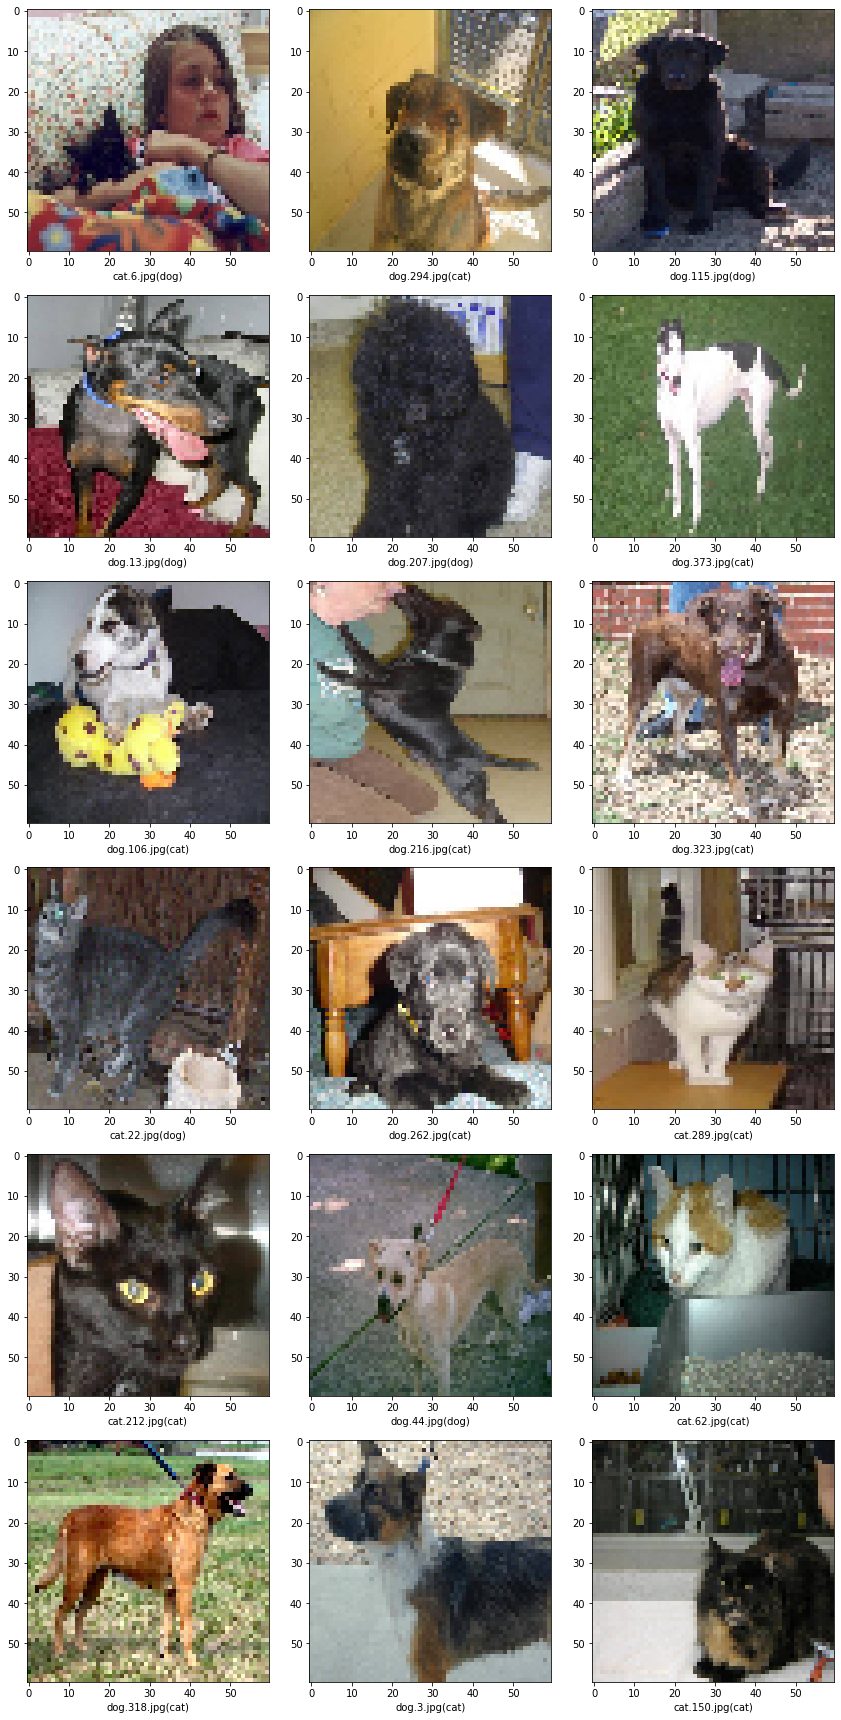

In [24]:
sample_test = validate_df.head(18)
sample_test.head()

plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['predicted']
    img = load_img("./dogs-vs-cats/train/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )

plt.tight_layout()
plt.show()

## **6. Callbacks function**

#### **6.1 Import callbacks**

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#### **6.2 Defining Checkpoint and Earlystop conditions**

In [26]:
checkpoint_filepath = '/tmp/checkpoint'
checkpoint = ModelCheckpoint(checkpoint_filepath,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 5, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

#### **6.3 Reducing our learning Rate on Plateau**

We can avoid having our oscillate around the global minimum by attempting to reduce the Learn Rate by a certain fact. If no improvement is seen in our monitored metric (val_loss typically), we wait a certain number of epochs (patience) then this callback reduces the learning rate by a factor

In [27]:
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

#### **6.4 Defining Callback list**

In [28]:
# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

#### **6.5 Stopping training early based on callbacks**

In [29]:
epochs = 10

history = model.fit(
    train_generator, 
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = 200//batch_size,
    steps_per_epoch = 800//batch_size,
)

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.6029 - accuracy: 0.6712
Epoch 1: val_loss improved from inf to 0.62381, saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
25/25 [==============================] - 4s 150ms/step - loss: 0.6029 - accuracy: 0.6712 - val_loss: 0.6238 - val_accuracy: 0.6458 - lr: 5.0000e-04
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.5507 - accuracy: 0.7362
Epoch 2: val_loss improved from 0.62381 to 0.58388, saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
25/25 [==============================] - 3s 136ms/step - loss: 0.5507 - accuracy: 0.7362 - val_loss: 0.5839 - val_accuracy: 0.6823 - lr: 5.0000e-04
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.4942 - accuracy: 0.7563
Epoch 3: val_loss did not improve from 0.58388
25/25 [==============================] - 2s 98ms/step - loss: 0.4942 - accuracy: 0.7563 - val_l

###End of Code